In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
G = [[4,1],[0,2],[1,3],[2,4],[3]] # array at the ith position contains the neighbouring nodes of node i
N = len(G) 
G_params = [0.5]*N # initially unbiased -> Bernoulli parameters
A_V = [0.8 for v in range(N)] # influence of samples -> alpha_v in paper
A_VU = [1/(len(G[v])+1) for v in range(N)] # all neighbours equally influence any node
M = 1 # number of Bernoulli variables
Beta = 0.75  
Lv = 0.167

def generate_samples(M,T): # for t time steps
    samples = []
    # samples for t=0
    samples.append([])
    for v in range(N):
        sample = []
        for m in range(M):
            sample.append(np.random.binomial(n=1, p=G_params[v]))
        samples[-1].append(sample)        
 
    for t in range(1,T):
        samples.append([])
        # determine the Bernoulli paremeters for t
        for v in range(N):
            influ = 0
            for Nv in G[v]:
                Nv_p = sum(samples[t-1][Nv]) # number of ones
                influ += A_VU[v]*Nv_p/M
            influ += A_VU[v]*samples[t-1][v][0]/M # influenced by self
    
            # updating the Bernoulli parameters
            G_params[v] = (1 - A_V[v])*((1-Beta)*np.random.binomial(n=1,p=0.7) + Beta*Lv) + A_V[v]*influ
            
            sample = []
            for m in range(M):
                sample.append(np.random.binomial(n=1, p=G_params[v]))
            samples[-1].append(sample) 

    return samples

In [3]:
from collections import Counter

def P_estimator(S): # where S is a 3d array, containing samples from T time instances, and every instance contains N*M binary samples
    T, N, M = len(S), len(S[0]), len(S[0][0])
    S1 = []
    for t in range(T):
        S1.append([])
        for v in range(N):
            S1[-1].append(sum(S[t][v])/len(S[t][v]))
    
    S2 = [[x[v] for x in S1] for v in range(N)] # each array contains samples of one particular node
    P_V = []
    for v in range(N):
        counts = Counter(S2[v])
        P_V.append({key: value/T for key, value in counts.items()})

    return P_V        

In [4]:
def P_v_plus_Q(v_plus, Q, S): # v_plus-> node-v value @ (t+1), Q is a subset of nodes [include node-v here if required]
    T, N = len(S), len(S[0])
    S1 = []
    for t in range(T):
        S1.append([])
        for v in range(N):
            S1[-1].append(sum(S[t][v])/len(S[t][v]))
    S2 = []
    for t in range(T-1):
        sample = tuple([S1[t+1][v_plus]] + [S1[t][v] for v in Q]) # tuples is required for hashing
        S2.append(sample)

    counts = Counter(S2)
    P = {key: value/T for key, value in counts.items()} # P([V(t+1),Q(t)])

    return P                

In [5]:
def P_Q(Q, S):
    T, N = len(S), len(S[0])
    S1 = []
    for t in range(T):
        S1.append([])
        for v in range(N):
            S1[-1].append(sum(S[t][v])/len(S[t][v]))
    S2 = []
    for t in range(T-1):
        sample = tuple([S1[t][v] for v in Q]) # tuples is required for hashing
        S2.append(sample)

    counts = Counter(S2)
    P = {key: value/T for key, value in counts.items()} # P(Q(t))

    return P

In [20]:
import math
def H(prob_dist):
    return -sum(p * math.log2(p) for p in prob_dist if p > 0)

def P_Q_past(Q, D, S): # D is a list of time stamps. for coin-toss model D = [0,d]. P({Q(t),Q(t-d)})
    T, N = len(S), len(S[0])
    S1 = []
    for t in range(T):
        S1.append([])
        for v in range(N):
            S1[-1].append(sum(S[t][v])/len(S[t][v]))
    S2 = []
    for t in range(D[-1],T-1):
        sample = []
        for d in D:
            sample += [S1[t-d][v] for v in Q]
        sample = tuple(sample) # tuples is required for hashing
        S2.append(sample)

    counts = Counter(S2)
    P = {key: value/T for key, value in counts.items()} # P(Q(t))

    return P

def P_v_plus_Q_past(v_plus, Q, D, S):
    T, N = len(S), len(S[0])
    S1 = []
    for t in range(T):
        S1.append([])
        for v in range(N):
            S1[-1].append(sum(S[t][v])/len(S[t][v]))
    S2 = []
    for t in range(D[-1],T-1):
        sample = []
        for d in D:
            sample += [S1[t-d][v] for v in Q]
        sample = tuple([S1[t+1][v_plus]] + sample) # tuples is required for hashing
        S2.append(sample)

    counts = Counter(S2)
    P = {key: value/T for key, value in counts.items()} # P(Q(t))

    return P

def H_v_plus_C_Q(v_plus, Q, S): # Q includes v
    Pr_v_plus_Q = P_v_plus_Q(v_plus, Q, S).values()
    Pr_Q = P_Q(Q, S).values()
    
    return H(Pr_v_plus_Q) - H(Pr_Q) 

def H_v_plus_C_Q_past(v_plus, Q, D, S): # H(v+ |{Q(t),Q(t-d)})
    Pr_v_plus_Q_past = P_v_plus_Q_past(v_plus, Q, D, S).values()
    Pr_Q_past = P_Q_past(Q, D, S).values()
    
    return H(Pr_v_plus_Q_past) - H(Pr_Q_past)

In [7]:
import copy


def RecGreedy(E, S): # E-> epsilon
    T, N = len(S), len(S[0])
    N_V = []
    for v in range(N):
        N_v ,T = [v], []
        iterate_1 = True
        while iterate_1:
            # print("iteration 1")
            T = copy.deepcopy(N_v) # temp neighbour nodes list
            iterate_2 = True
            T_C = [x for x in range(N) if x not in T] # complement of T
            last = -1
            if not len(T_C):
                break
            while iterate_2: # to add the last node appended to T as a legit neighbour node 
                # print("iteration 2")
                if not len(T_C):
                    # print("hoops")
                    # iterate_1 = False
                    N_v.append(last)
                    break
                # find out the node, that reduces the conditional entropy the most
                min_H_v_Q, min_T_C_v = 10**5, -1
                for T_C_v in T_C:
                    h = H_v_plus_C_Q(v, T + [T_C_v], S)                    
                    if h < min_H_v_Q:
                        min_H_v_Q = h
                        min_T_C_v = T_C_v
                        # print("comes here")
                if H_v_plus_C_Q(v, T, S) - min_H_v_Q > E/2:
                    # print("makes it here")
                    T.append(min_T_C_v)
                    T_C.remove(min_T_C_v)
                    last = min_T_C_v
                else:
                    # print("fails here")
                    iterate_2 = False
                    if last != -1:
                        # print("fails but good")
                        N_v.append(last)
                    else:
                        iterate_1 = False # no new node is appended to T, hence all legit neighbour nodes are added to N_v
        N_V.append(N_v)

    # print("neighbours of node v", N_V)

    return N_V
        

In [8]:
def generate_samples_coin_toss(d, T, pc): # pc -> coin toss probability
    samples = []
    # samples for t=0
    samples.append([])
    for v in range(N):
        sample = []
        for m in range(M):
            sample.append(np.random.binomial(n=1, p=G_params[v]))
        samples[-1].append(sample)        
 
    for t in range(1,T):
        samples.append([])
        # determine the Bernoulli paremeters for t
        C  = 0
        if t>d-1: # coin can be tossed 
            C = np.random.binomial(n=1, p=1-pc)    
        for v in range(N):
            influ = 0
            for Nv in G[v]:
                Nv_p = sum(samples[t-1][Nv]) # number of ones
                influ += A_VU[v]*Nv_p/M
            influ += A_VU[v]*samples[t-1- C*(d-1)][v][0]/M # influenced by self
    
            # updating the Bernoulli parameters
            G_params[v] = (1 - A_V[v])*((1-Beta)*np.random.binomial(n=1,p=0.7) + Beta*Lv) + A_V[v]*influ
            sample = []
            for m in range(M):
                sample.append(np.random.binomial(n=1, p=G_params[v]))
            samples[-1].append(sample) 

    return samples

In [21]:
def Mu(x):
    return 0.4*x # L = 0.4, Mu_max = 0.4

def generate_samples_random_Mv(T, Mu, M_): # Mu -> L-Lipschitz function, 
    samples = []
    # samples for t=0
    samples.append([])
    for v in range(N):
        sample = []
        M = min(np.random.poisson(Mu(0.5)),M_) + 1
        for m in range(M):
            sample.append(np.random.binomial(n=1, p=G_params[v]))
        samples[-1].append(sample)        
 
    for t in range(1,T):
        samples.append([])
        # determine the Bernoulli paremeters for t
        for v in range(N):
            influ = 0
            for Nv in G[v]:
                Nv_p = sum(samples[t-1][Nv]) # number of ones
                influ += A_VU[v]*Nv_p/len(samples[t-1][Nv])
            influ += A_VU[v]*sum(samples[t-1][v])/len(samples[t-1][v]) # influenced by self
    
            # updating the Bernoulli parameters
            G_params[v] = (1 - A_V[v])*((1-Beta)*np.random.binomial(n=1,p=0.7) + Beta*Lv) + A_V[v]*influ
            sample = []
            M = min(np.random.poisson(Mu(G_params[v])),M_) + 1
            for m in range(M):
                sample.append(np.random.binomial(n=1, p=G_params[v]))
            samples[-1].append(sample) 

    return samples

In [22]:
def generate_samples_r_Mv_r_d(T, Mu, M_, d): # [t-d,t-d+1,....t] -> randomly choose a sample to go forward
    samples = []
    # samples for t=0
    samples.append([])
    for v in range(N):
        sample = []
        M = min(np.random.poisson(Mu(0.5)),M_) + 1
        for m in range(M):
            sample.append(np.random.binomial(n=1, p=G_params[v]))
        samples[-1].append(sample)        
 
    for t in range(1,T):
        samples.append([])
        C = 0
        if t>d:
            C = np.random.randint(0, d+1)
        # determine the Bernoulli paremeters for t
        for v in range(N):
            influ = 0
            for Nv in G[v]:
                Nv_p = sum(samples[t-1-C][Nv]) # number of ones
                influ += A_VU[v]*Nv_p/len(samples[t-1-C][Nv])
            influ += A_VU[v]*sum(samples[t-1-C][v])/len(samples[t-1-C][v]) # influenced by self
    
            # updating the Bernoulli parameters
            G_params[v] = (1 - A_V[v])*((1-Beta)*np.random.binomial(n=1,p=0.7) + Beta*Lv) + A_V[v]*influ
            sample = []
            M = min(np.random.poisson(Mu(G_params[v])),M_) + 1
            for m in range(M):
                sample.append(np.random.binomial(n=1, p=G_params[v]))
            samples[-1].append(sample)

    return samples

def sample_geometric_in_range(p, d):
    while True:
        x = np.random.geometric(p) - 1  # Shift to start from 0
        if x <= d:
            return x

def generate_samples_r_Mv_r_d1(T, Mu, M_, d): # [t-d,t-d+1,....t] -> randomly choose a sample to go forward
    samples = []
    # samples for t=0
    samples.append([])
    for v in range(N):
        sample = []
        M = min(np.random.poisson(Mu(0.5)),M_) + 1
        for m in range(M):
            sample.append(np.random.binomial(n=1, p=G_params[v]))
        samples[-1].append(sample)        
 
    for t in range(1,T):
        samples.append([])
        C = 0
        if t>d:
            C = sample_geometric_in_range(0.1, d)
        # determine the Bernoulli paremeters for t
        for v in range(N):
            influ = 0
            for Nv in G[v]:
                Nv_p = sum(samples[t-1-C][Nv]) # number of ones
                influ += A_VU[v]*Nv_p/len(samples[t-1-C][Nv])
            influ += A_VU[v]*sum(samples[t-1-C][v])/len(samples[t-1-C][v]) # influenced by self
    
            # updating the Bernoulli parameters
            G_params[v] = (1 - A_V[v])*((1-Beta)*np.random.binomial(n=1,p=0.7) + Beta*Lv) + A_V[v]*influ
            sample = []
            M = min(np.random.poisson(Mu(G_params[v])),M_) + 1
            for m in range(M):
                sample.append(np.random.binomial(n=1, p=G_params[v]))
            samples[-1].append(sample)

    return samples

def generate_samples_r_Mv_coin_toss(T, Mu, M_, d, pc):
    samples = []
    # samples for t=0
    samples.append([])
    for v in range(N):
        sample = []
        M = min(np.random.poisson(Mu(0.5)),M_) + 1
        for m in range(M):
            sample.append(np.random.binomial(n=1, p=G_params[v]))
        samples[-1].append(sample)        
 
    for t in range(1,T):
        samples.append([])
        C = 0
        if t>d:
            C = np.random.binomial(n=1, p=(1-pc))
        # determine the Bernoulli paremeters for t
        for v in range(N):
            influ = 0
            for Nv in G[v]:
                Nv_p = sum(samples[t-1-C*d][Nv]) # number of ones
                influ += A_VU[v]*Nv_p/len(samples[t-1-C*d][Nv])
            influ += A_VU[v]*sum(samples[t-1-C*d][v])/len(samples[t-1-C*d][v]) # influenced by self
    
            # updating the Bernoulli parameters
            G_params[v] = (1 - A_V[v])*((1-Beta)*np.random.binomial(n=1,p=0.7) + Beta*Lv) + A_V[v]*influ
            sample = []
            M = min(np.random.poisson(Mu(G_params[v])),M_) + 1
            for m in range(M):
                sample.append(np.random.binomial(n=1, p=G_params[v]))
            samples[-1].append(sample)

    return samples

In [23]:
def RecGreedy_1(E,S,D): # for the coin toss, Y(t) = {y(t), y(t-d)} --> Markov chain
    T, N = len(S), len(S[0])
    N_V = []
    for v in range(N):
        N_v ,T = [v], []
        iterate_1 = True
        while iterate_1:
            # print("iteration 1")
            T = copy.deepcopy(N_v) # temp neighbour nodes list
            iterate_2 = True
            T_C = [x for x in range(N) if x not in T] # complement of T
            last = -1
            if not len(T_C):
                break
            while iterate_2: # to add the last node appended to T as a legit neighbour node 
                # print("iteration 2")
                if not len(T_C):
                    # print("hoops")
                    # iterate_1 = False
                    N_v.append(last)
                    break
                # find out the node, that reduces the conditional entropy the most
                min_H_v_Q, min_T_C_v = 10**5, -1
                for T_C_v in T_C:
                    h = H_v_plus_C_Q_past(v, T + [T_C_v], D,S)                    
                    if h < min_H_v_Q:
                        min_H_v_Q = h
                        min_T_C_v = T_C_v
                        # print("comes here")
                if H_v_plus_C_Q_past(v, T, D,S) - min_H_v_Q > E/2:
                    # print("makes it here")
                    T.append(min_T_C_v)
                    T_C.remove(min_T_C_v)
                    last = min_T_C_v
                else:
                    # print("fails here")
                    iterate_2 = False
                    if last != -1:
                        # print("fails but good")
                        N_v.append(last)
                    else:
                        iterate_1 = False # no new node is appended to T, hence all legit neighbour nodes are added to N_v
        N_V.append(N_v)

    # print("neighbours of node v", N_V)

    return N_V

In [24]:
G = [[1], [0, 2], [3, 1], [2, 4], [3,5], [4,6],[5]] 

# G = [[1,3],[0,2,4],[1,5],[0,4,6],[1,3,5,7],[2,4,8],[3,7],[4,6,8],[5,7]] # array at the ith position contains the neighbouring nodes of node i
N = len(G) 
G_params = [0.5]*N # initially unbiased -> Bernoulli parameters
A_V = [0.8 for v in range(N)] # influence of samples -> alpha_v in paper
A_VU = [1/(len(G[v])+1) for v in range(N)] # all neighbours equally influence any node
# s1 = generate_samples_r_Mv_r_d(100000,Mu,3,20)

In [25]:
def verify(a):
    for v in range(len(a)):
        s = set(a[v][1:])
        if s != set(G[v]):
            return 0
    return 1    

In [26]:
def generate_samples_coin_toss_subset(T, Mu, M_, d, pc, N1):  # N1 is a list of nodes that toss coin
    N0 = [x for x in list(range(N)) if x not in N1]
    samples = []
    # samples for t=0
    samples.append([])
    for v in range(N):
        sample = []
        M = min(np.random.poisson(Mu(0.5)),M_) + 1
        for m in range(M):
            sample.append(np.random.binomial(n=1, p=G_params[v]))
        samples[-1].append(sample)        
 
    for t in range(1,T):
        samples.append([])
        C = 0
        if t>d:
            C = np.random.binomial(n=1, p=(1-pc))
        # determine the Bernoulli paremeters for t
        for v in N1:
            influ = 0
            for Nv in G[v]:
                Nv_p = sum(samples[t-1-C*d][Nv]) # number of ones
                influ += A_VU[v]*Nv_p/len(samples[t-1-C*d][Nv])
            influ += A_VU[v]*sum(samples[t-1-C*d][v])/len(samples[t-1-C*d][v]) # influenced by self

            # updating the Bernoulli parameters
            G_params[v] = (1 - A_V[v])*((1-Beta)*np.random.binomial(n=1,p=0.7) + Beta*Lv) + A_V[v]*influ
            sample = []
            M = min(np.random.poisson(Mu(G_params[v])),M_) + 1
            for m in range(M):
                sample.append(np.random.binomial(n=1, p=G_params[v]))
            samples[-1].append(sample)


        for v in N0:
            influ = 0
            for Nv in G[v]:
                Nv_p = sum(samples[t-1][Nv]) # number of ones
                influ += A_VU[v]*Nv_p/len(samples[t-1][Nv])
            influ += A_VU[v]*sum(samples[t-1][v])/len(samples[t-1][v]) # influenced by self    


            # updating the Bernoulli parameters
            G_params[v] = (1 - A_V[v])*((1-Beta)*np.random.binomial(n=1,p=0.7) + Beta*Lv) + A_V[v]*influ
            sample = []
            M = min(np.random.poisson(Mu(G_params[v])),M_) + 1
            for m in range(M):
                sample.append(np.random.binomial(n=1, p=G_params[v]))
            samples[-1].append(sample)

    return samples

In [27]:
def gen_samp(T, Mu, M_, d, pc):
    samples = []
    tail_counts = 0
    trck = 0 # to keep track of the no toss counts
    # samples for t=0
    samples.append([])
    for v in range(N):
        sample = []
        M = min(np.random.poisson(Mu(0.5)),M_) + 1
        for m in range(M):
            sample.append(np.random.binomial(n=1, p=G_params[v]))
        samples[-1].append(sample)        
 
    for t in range(1,T):
        samples.append([])
        C = 0
        if t>d and trck==0:
            C = np.random.binomial(n=1, p=(1-pc))
            tail_counts += C
            if C:
                trck = d
        elif trck:
            trck -= 1
            
        # determine the Bernoulli paremeters for t
        for v in range(N):
            influ = 0
            for Nv in G[v]:
                Nv_p = sum(samples[t-1-C*d][Nv]) # number of ones
                influ += A_VU[v]*Nv_p/len(samples[t-1-C*d][Nv])
            influ += A_VU[v]*sum(samples[t-1-C*d][v])/len(samples[t-1-C*d][v]) # influenced by self
    
            # updating the Bernoulli parameters
            G_params[v] = (1 - A_V[v])*((1-Beta)*np.random.binomial(n=1,p=0.7) + Beta*Lv) + A_V[v]*influ
            sample = []
            M = min(np.random.poisson(Mu(G_params[v])),M_) + 1
            for m in range(M):
                sample.append(np.random.binomial(n=1, p=G_params[v]))
            samples[-1].append(sample)
    # print("# tails = ", tail_counts)
    return samples

In [29]:
E =[0.08]
for e in E:
    c = 0
    for _ in range(30):
        d = 30
        # s1 = generate_samples(1, 3000)
        # s1 = generate_samples_coin_toss_subset(35000, Mu, 1, d, 0.9 ,[2,3,4])
        s1 = gen_samp(4600, Mu, 1, d, 0.9)
        c += verify(RecGreedy_1(e, s1,[d]))
        # c += verify(RecGreedy_1(0.18,s3,[0,d]))
    print(c/30)    

0.0


In [ ]:
T = 2600, p = 0.9, d = 30
0.05, 0
0.55, 0.2
0.06, 0.733
0.065, 0.933
0.07, 0.966
0.075, 1
0.08 , 
0.085, 1
0.09 , 
0.095, 1
0.1, 0.933 
0.12, 0.466
0.14, 
0.15, 0

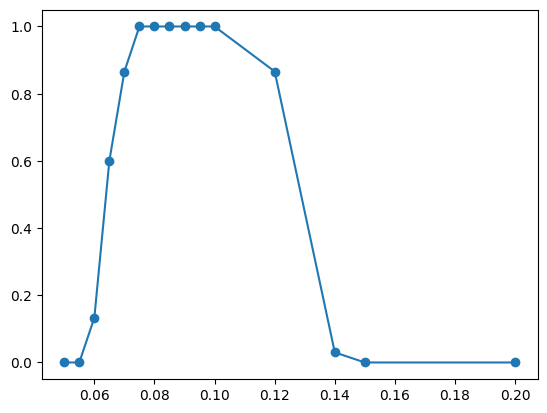

In [ ]:
# ring - 7nodes, T = 2400
prb = [0,0,0.133,0.6,0.866,1,1,1,1,1,1,0.866,0.03,0,0]
Es = [0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.12,0.14,0.15, 0.2]
plt.plot(Es,prb,marker="o")

In [ ]:
c = 0
for _ in range(30):
    d = 30 
    # s1 = generate_samples(1, 3000)
    # s1 = generate_samples_coin_toss_subset(35000, Mu, 1, d, 0.9 ,[2,3,4])
    s1 = generate_samples_r_Mv_coin_toss(2400, Mu, 1, d, 1)
    c += verify(RecGreedy(0.07, s1))
    # c += verify(RecGreedy_1(0.18,s3,[0,d]))
print(c/30)    

In [8]:
# T = 10000, tree 7 nodes 
Es_t = [0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.08, 0.085]
prb_t = [0, 0.1, 0.9, 1, 1, 1, 1, 1, 0.823, 0.23, 0]
Es_0p9_d_30_t = [0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08]
prb_0p9_d_30_t = [0.0, 0.033, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 0.07, 0.0266, 0.0]
Es_0p7_d_30_t = [0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.08]
prb_0p7_d_30_t = [0, 0.83, 1, 1, 1, 0.96, 0.933, 0.533, 0.066, 0]

In [27]:
# T = 2600, a line of 7 nodes
Es_l = [0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.095, 0.1, 0.12, 0.15, 0.2]
prb_l = [0.033, 0.166, 0.633, 0.966, 1.0, 1.0, 1.0, 1.0, 1.0, 0.966, 0.7, 0.0, 0.0]
Es_0p9_d_30_l = [0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.085, 0.095, 0.1, 0.12, 0.15]
prb_0p9_d_30_l = [0.0, 0.2, 0.733, 0.933, 0.966, 1.0, 1.0, 1.0, 0.933, 0.466, 0.0]
Es_0p7_d_30_l = [0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.12, 0.15]
prb_0p7_d_30_l = [0.03, 0.2, 0.66, 0.933, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.833, 0.46, 0.0]

Es_0p9_d_5 = [0.05, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.1, 0.12, 0.15]
prb_0p9_d_5 = [0.0, 0.7, 0.8, 0.966, 1.0, 1.0, 0.966, 0.95, 0.766, 0.1, 0.0]
Es_0p7_d_5 = [0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.08, 0.085, 0.09, 0.1, 0.15]
prb_0p7_d_5 = [0.0, 0.033, 0.2, 0.8, 0.866, 1.0, 1.0, 0.93, 0.833, 0.4, 0.0]

[]

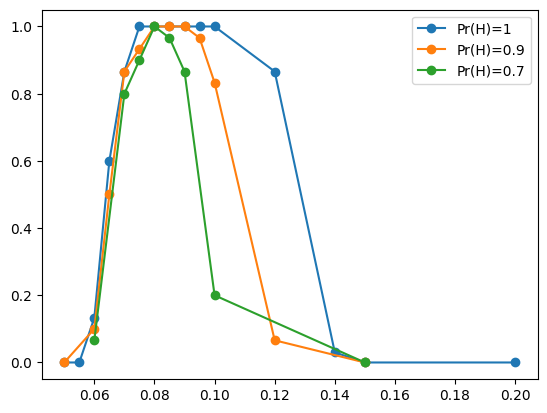

In [28]:
# ring - 7nodes, T = 2400
prb = [0,0,0.133,0.6,0.866,1,1,1,1,1,1,0.866,0.03,0,0]
Es = [0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.12,0.14,0.15, 0.2]
# p_tail = 0.1, d = 30  
Es_0p9_d_30 = [0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.1, 0.12, 0.14, 0.15, 0.2]
prb_0p9_d_30 = [0.0, 0.033, 0.133, 0.633, 0.8, 0.966, 1.0, 1, 0.966, 0.933, 0.366, 0, 0.0, 0.0]
Es_0p7_d_30 = [0.05, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.1, 0.11,0.12, 0.15, 0.2]
prb_0p7_d_30 = [0.0, 0.2, 0.5, 0.866, 0.966, 1.0, 1.0, 1.0, 0.966, 0.7, 0.2, 0.0, 0.0]
Es_0p9_d_5 = [0.05, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.12, 0.15]
prb_0p9_d_5 = [0.0, 0.1, 0.5, 0.866, 0.933, 1.0, 1.0, 1.0, 0.966, 0.833, 0.066, 0.0]
Es_0p7_d_5 = [0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.1, 0.15]
prb_0p7_d_5 = [0.066, 0.8, 0.9, 1.0, 0.966, 0.866, 0.2, 0.0]
plt.plot(Es,prb,marker="o",label="Pr(H)=1")
plt.plot(Es_0p9_d_5,prb_0p9_d_5,marker="o",label="Pr(H)=0.9")
plt.plot(Es_0p7_d_5,prb_0p7_d_5,marker="o",label="Pr(H)=0.7")
plt.legend()
plt.plot()

[]

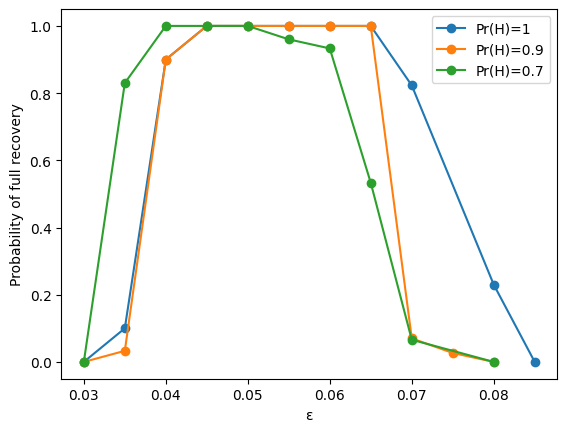

In [10]:
plt.plot(Es_t,prb_t,marker="o",label="Pr(H)=1")
plt.plot(Es_0p9_d_30_t,prb_0p9_d_30_t,marker="o",label="Pr(H)=0.9")
plt.plot(Es_0p7_d_30_t,prb_0p7_d_30_t,marker="o",label="Pr(H)=0.7")
plt.xlabel("ε")
plt.ylabel("Probability of full recovery")
plt.legend()
plt.plot()

In [4]:
lb(10)

0.30151134457776363

In [1]:
import numpy as np
def f(e):
    return e**2 / (16* 27* 3**(2*np.log(3)/e))

In [15]:
f(0.5)

np.float64(4.632027908251165e-06)

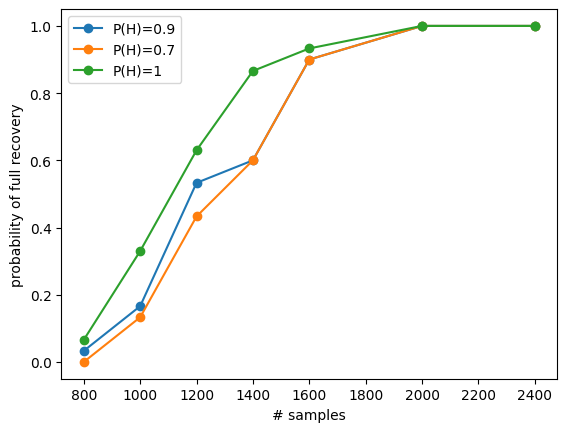

In [12]:
Ts = [800, 1000, 1200, 1400, 1600, 2000, 2400]
prbs = [0.066,0.33, 0.63, 0.866, 0.933, 1, 1]
prbs_0p9 = [0.033, 0.166, 0.533,0.6,0.9, 1, 1]
prbs_0p7 = [0, 0.133, 0.433, 0.6, 0.9, 1, 1]
plt.plot(Ts, prbs_0p9,marker='o',label="P(H)=0.9")
plt.plot(Ts, prbs_0p7,marker='o',label="P(H)=0.7")
plt.plot(Ts, prbs,marker='o',label="P(H)=1")
plt.xlabel("# samples")
plt.ylabel("probability of full recovery")
plt.legend()